In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Import error

If import fails clone both repos and add them to sys path:

```
!pip install EXCAT-Sync
```

In [4]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi
from exact_sync.v1.api.products_api import ProductsApi
from exact_sync.v1.api.teams_api import TeamsApi

In [5]:
from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [6]:
from pathlib import Path
import numpy as np
from glob import glob
import pickle
import torch
from random import randint
import pyvips

In [7]:
from sklearn.neighbors import KDTree
import cv2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from fastai import *
from fastai.vision import *
from torchvision import datasets, models, transforms

In [8]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.0.0
torch cuda    : 10.0 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : Quadro P5200

=== Environment === 
platform      : Windows-10-10.0.17763-SP0
conda env     : fastai
python        : D:\Programme\Anaconda\envs\fastai\python.exe
sys.path      : D:\Programme\Anaconda\envs\fastai\python36.zip
D:\Programme\Anaconda\envs\fastai\DLLs
D:\Programme\Anaconda\envs\fastai\lib
D:\Programme\Anaconda\envs\fastai

C:\Users\c.marzahl\AppData\Roaming\Python\Python36\site-packages
D:\Programme\Anaconda\envs\fastai\lib\site-packages
D:\ProgProjekte\Python\tensorflow\cocoapi\PythonAPI\pycocotools
D:\ProgProjekte\Python\fastai\fastai
D:\ProgProjekte\Python\Promotion\ObjectDetection
D:\ProgProjekte\Python\SlideRunner
D:\ProgProjekte\Python\Promotion\EXACT-Sync
D:\Programme\Anaconda\envs\fastai\lib\site-packages\win32
D:\Programme\Anacond

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [11]:
path = Path('D:/Datasets/AstmaPferd/Patches/')
image_folder = Path('Patches')

In [12]:
tfms = get_transforms(flip_vert=False)
size=64
data = (ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms, size=size)).databunch().normalize()

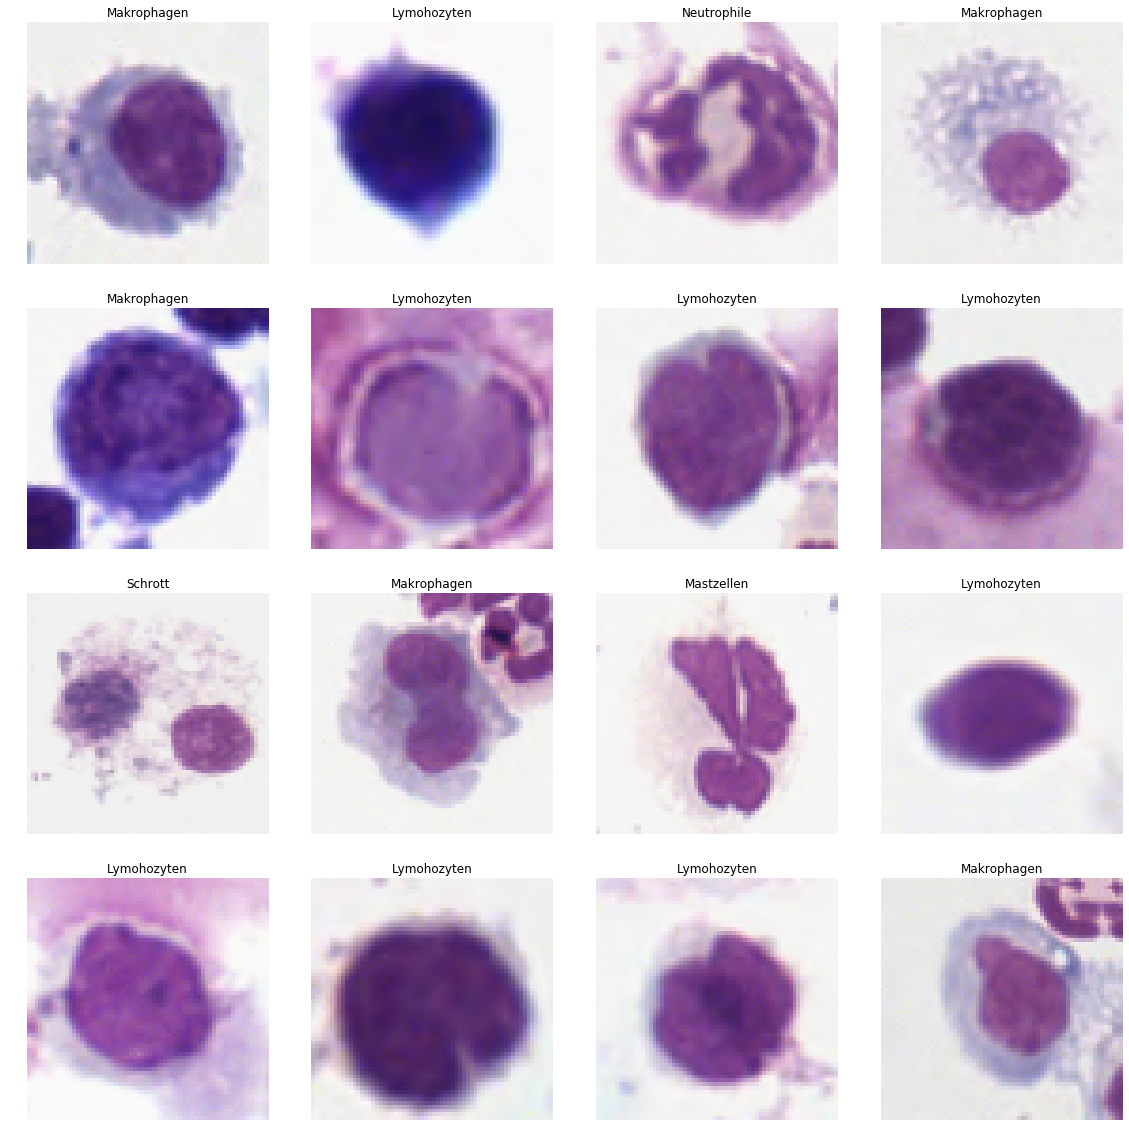

In [14]:
data.show_batch(rows=4)

# Train Model

In [15]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], callback_fns=[])

In [16]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.362076,0.278658,0.912538,04:20
1,0.253744,0.215739,0.932094,04:21
2,0.233562,0.205843,0.934147,04:20


In [18]:
def pil2tensor(image, dtype:np.dtype):
    "Convert PIL style `image` array to torch style image tensor."
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(dtype, copy=False) )

def open_image(fn:Path, div:bool=True, convert_mode:str='RGB'):
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode).resize((size,size))
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return x

## Last feature layer bevor classifier

TODO: https://github.com/KevinMusgrave/pytorch-metric-learning

In [19]:
trained_model = nn.Sequential(learn.model[0], learn.model[1][:7]).to(device)

In [20]:
learn.model[1][:7]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Extract features for each image

In [36]:
mean, std = to_np(data.stats[0]), to_np(data.stats[1])
paths = []
batch_size = 2
results = []

In [37]:
list(Path('D:/Datasets/AstmaPferd/Patches/').glob("*/*.png"))[:5]

[WindowsPath('D:/Datasets/AstmaPferd/Patches/Eosinophile/BAL 1 Spray 2_11939_5765_42_42.png'),
 WindowsPath('D:/Datasets/AstmaPferd/Patches/Eosinophile/BAL 1 Spray 2_12309_5358_78_78.png'),
 WindowsPath('D:/Datasets/AstmaPferd/Patches/Eosinophile/BAL 1 Spray 2_12393_6191_58_58.png'),
 WindowsPath('D:/Datasets/AstmaPferd/Patches/Eosinophile/BAL 1 Spray 2_12427_18340_64_64.png'),
 WindowsPath('D:/Datasets/AstmaPferd/Patches/Eosinophile/BAL 1 Spray 2_12953_27560_80_80.png')]

In [38]:
with torch.no_grad():
    image_batch, paths_batch = [], []
    for path in tqdm(Path('D:/Datasets/AstmaPferd/Patches/').glob("*/*.png")):
        image = open_image(str(path))
        image = transforms.Normalize(mean, std)(image)

        image_batch.append(image[None, :, :, :])
        paths_batch.append(path)

        if len(image_batch) == batch_size:
            features_batch = trained_model(torch.cat(image_batch).to(device))

            for path, features in zip(paths_batch, features_batch):
                results.append({
                    'Path': str(path),
                    'Label': str(path.parent.stem),
                    'Features': np.array(features_batch.cpu())[0]
                })
            image_batch, paths_batch = [], []

## Scale and PCA / TSNE / UMAP

TODO: https://github.com/lmcinnes/umap

In [40]:
# Scale
scaler = StandardScaler()

features = np.array([result['Features'] for result in results])
scaler.fit(features)

norm_features = scaler.transform(features)

In [ ]:
import umap

pca_features = umap.UMAP().fit_transform(norm_features)

In [2]:
# Result image size
size = 64
x_total_size = 10000
y_total_size = 10000

image_size = size

### Scale features in that range

In [ ]:
min_x = pca_features[:, 0].min()
min_y = pca_features[:, 1].min()

pca_features[:, 0] += abs(min_x)
pca_features[:, 1] += abs(min_y)

max_x = pca_features[:, 0].max()
max_y = pca_features[:, 1].max()

pca_features[:, 0] *= ((x_total_size-(2*image_size)) / max_x)
pca_features[:, 1] *= ((y_total_size-(2*image_size)) / max_y)

In [ ]:
new_results = []
for entry, norm_feature, pca_feature in zip(results, norm_features, pca_features):
     entry['norm_feature'] = norm_feature
     entry['pca_feature'] = pca_feature
     new_results.append(entry)
results = new_results

In [ ]:
import matplotlib

colors = {}
for i, name in enumerate(data.classes):
    colors[name] = np.array(matplotlib.cm.get_cmap('Spectral')(i / data.c))[:3][None]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

for result in results:
    x,y = result['pca_feature']

    ax.scatter(x, y, c=colors[result['Label']], label=result['Label'])

ax.set(ylabel="Features Y", xlabel="Features X", title="PCA-Features")

## Create Image

In [ ]:
target_file = Path('Asthma_{}.tif'.format(str(randint(0, 1000))))
target_file

In [ ]:
image_size = size
image_size

In [ ]:
center_x, center_y = [], []
for x in range(0, x_total_size - image_size, image_size):
    for y in range(0, x_total_size - image_size, image_size):
        center_x.append(x)
        center_y.append(y)

In [ ]:
Centers = np.dstack((center_x, center_y))[0]

big_image = np.zeros(shape=(y_total_size, x_total_size, 3), dtype=np.uint8)
big_image += 255
big_image.shape

In [ ]:
from tqdm import tqdm
annotations = []
for result in tqdm(results):

    feature = result['pca_feature']
    label = result['Label']
    path = result['Path']

    image = cv2.resize(cv2.imread(str(path))[:, :, [2, 1, 0]], (image_size, image_size))

    min_x, min_y = int(feature[0]), int(feature[1])

    dists = np.hypot(Centers[:, 0] - min_x, Centers[:, 1] - min_y)
    ind = np.argmin(dists) 
    min_x, min_y = Centers[ind].flatten()
    min_x, min_y = int(min_x), int(min_y)
    Centers = np.delete(Centers, ind.flatten(), axis=0)

    max_x, max_y = min_x + image_size, min_y + image_size
    
    big_image[min_y:max_y, min_x:max_x] = image

    vector = json.dumps({"x1": min_x + 3, "y1": min_y + 3, "x2": max_x - 3, "y2": max_y - 3})
    #row = "{0}|{1}|{2}|{3}|\n".format(target_file.name, label, vector, Path(path).stem)
    row = "{0}|{1}|{2}|\n".format(target_file.name, label, vector)
    annotations.append(row)

In [ ]:
height, width, bands = big_image.shape
linear = big_image.reshape(width * height * bands)
vi = pyvips.Image.new_from_memory(linear.data, width, height, bands, 'uchar')
vi.tiffsave(str(target_file), tile=True, compression='lzw', bigtiff=True, pyramid=True)

In [ ]:
import openslide
import matplotlib.pyplot as plt

level = 1
slide = openslide.open_slide(str(target_file))
slide.level_dimensions

In [ ]:
patch = np.array(slide.read_region(location=(0, 0),
                                            level=2, size=slide.level_dimensions[2]))[:, :, :3]

plt.imshow(patch)

# Upload to EXACT

0.   Create Team
1.   Create Imageset
2.   Create Products
3.   Create Annotation Types
4.   Upload Image
5.   Upload Annotations

In [13]:
configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "http://127.0.0.1:8000"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)
product_api = ProductsApi(client)
team_api = TeamsApi(client)

## Create Team if not exists

In [15]:
teams = team_api.list_teams(name="cluster_asthma_team")
if teams.count == 0:
    team = Team(name="cluster_asthma_team")
    team = team_api.create_team(body=team) 
else:
    team = teams.results[0]

## Create Imageset if not exists

In [16]:
image_sets = image_sets_api.list_image_sets(name="cluster_asthma_imageset")
if image_sets.count == 0:
    image_set = ImageSet(name="cluster_asthma_imageset", team=team.id)
    image_set = image_sets_api.create_image_set(body=image_set)
else:
    image_set = image_sets.results[0]

## Create Product if not exists

In [17]:
products = product_api.list_products(name="cluster_product")
if products.count == 0:
    product = Product(name="cluster_product", imagesets=[image_set.id], team=team.id)
    product = product_api.create_product(body=product)
else:
    product = products.results[0]

## Create Annotation Types if not exists

In [18]:
data.classes

['Eosinophile',
 'Erythrozyt',
 'Lymohozyten',
 'Makrophagen',
 'Mastzellen',
 'Mehrkernige',
 'Neutrophile',
 'Schrott',
 'Weitere']

In [22]:
annotation_types = {}

In [24]:
for y in np.unique(data.classes):
    annotation_type_server = annotation_types_api.list_annotation_types(name=y, product=product.id)
    if annotation_type_server.count == 0:
        vector_type = int(AnnotationType.VECTOR_TYPE.BOUNDING_BOX)
        annotation_type = AnnotationType(name=str(y), product=product.id, vector_type=vector_type)
        annotation_type = annotation_types_api.create_annotation_type(body=annotation_type)
        annotation_types[y] = annotation_type
    else:
        annotation_types[y] = annotation_type_server.results[0]
        

## Upload Image

In [ ]:
image_type = int(Image.ImageSourceTypes.DEFAULT)
image = images_api.create_image(file_path=target_file, image_type=image_type, image_set=image_set.id).results[0]

## Upload Annotations

In [ ]:
threads = []
for row in tqdm(annotations):
    name, label, vector = row.split('|')[:3]
    unique_identifier = str(uuid.uuid4())
    
    annotation_type = annotation_types[label]
    
    annotation = Annotation(annotation_type=annotation_type.id, vector=vector, image=image.id, unique_identifier=unique_identifier)
    thread = annotations_api.create_annotation(body=annotation, async_req=True)
    threads.append(thread)

### Wait that all annotations are uploaded

In [ ]:
while (len(threads) > 0):
    for thread in threads:
        if thread.ready():
            data.results += thread.get().results
            threads.remove(thread)
    sleep(0.25)